In [25]:
!pip install openai-whisper pydub librosa transformers scikit-learn matplotlib numpy


In [26]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# STEP 2: List Uploaded Audio Files (.m4a)
import os

audio_folder = '/content/drive/MyDrive/memotag_audio'
audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.m4a')]

print("Audio files:", audio_files)


Audio files: ['Recording (11).m4a', 'Recording (12).m4a', 'Recording (13).m4a', 'Recording (14).m4a', 'Recording (16).m4a']


In [28]:
# STEP 3: Install Whisper + Dependencies
!pip install -q git+https://github.com/openai/whisper.git
!sudo apt update && sudo apt install ffmpeg -y

import whisper
model = whisper.load_model("base")


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 257 kB in 2s (156 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
37 pack

In [29]:
# STEP 4: Transcribe Audio Using Whisper
transcripts = {}
for file in audio_files:
    path = os.path.join(audio_folder, file)
    result = model.transcribe(path)
    transcripts[file] = result['text']
    print(f"{file}: {result['text']}")


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Recording (11).m4a:  This morning I made some coffee, watered the plants and started reading the newspaper. It was a peaceful start to the day.


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Recording (12).m4a:  I was trying to find my glasses this morning, but I couldn't remember where I kept them.


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Recording (13).m4a:  I went to the what do you call it the place with groceries. Oh yeah the supermarket. I needed some X.


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Recording (14).m4a:  I spoke to my daughter yesterday or maybe it was my niece. We talked about something important, but I forgot.


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Recording (16).m4a:  I was planning to go to the grocery store but then I remembered I needed to finish some work first and now I can't recall what else I had to do today.


In [30]:
# STEP 5: Feature Extraction (Speech + Text Features)
import re
import numpy as np
import librosa

def extract_features(file, transcript):
    y, sr = librosa.load(os.path.join(audio_folder, file))
    duration = librosa.get_duration(y=y, sr=sr)

    word_count = len(transcript.split())
    speech_rate = word_count / duration

    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_vals = pitches[magnitudes > np.median(magnitudes)]
    pitch_std = np.std(pitch_vals) if len(pitch_vals) > 0 else 0

    hesitations = len(re.findall(r"\b(uh|um|er|ah|hmm)\b", transcript.lower()))

    intervals = librosa.effects.split(y, top_db=25)
    pauses = sum([1 for i in range(1, len(intervals)) if (intervals[i][0] - intervals[i-1][1]) > sr * 0.3])

    return {
        "file": file,
        "duration": duration,
        "speech_rate": speech_rate,
        "pitch_std": pitch_std,
        "hesitations": hesitations,
        "pauses": pauses
    }

features = [extract_features(f, transcripts[f]) for f in transcripts]


<ipython-input-30-eac500145178>:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(os.path.join(audio_folder, file))
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-30-eac500145178>:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(os.path.join(audio_folder, file))
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-30-eac500145178>:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(os.path.join(audio_folder, file))
/usr/loca

                 file   duration  speech_rate    pitch_std  hesitations  \
0  Recording (11).m4a   8.789342     2.503031  1119.248291            0   
1  Recording (12).m4a  10.069342     1.688293  1133.525269            0   
2  Recording (13).m4a  12.288027     1.708981  1108.048096            0   
3  Recording (14).m4a  12.565351     1.591679  1185.372070            0   
4  Recording (16).m4a  16.042676     1.994680  1077.470703            0   

   pauses  
0       2  
1       1  
2       2  
3       2  
4       0  


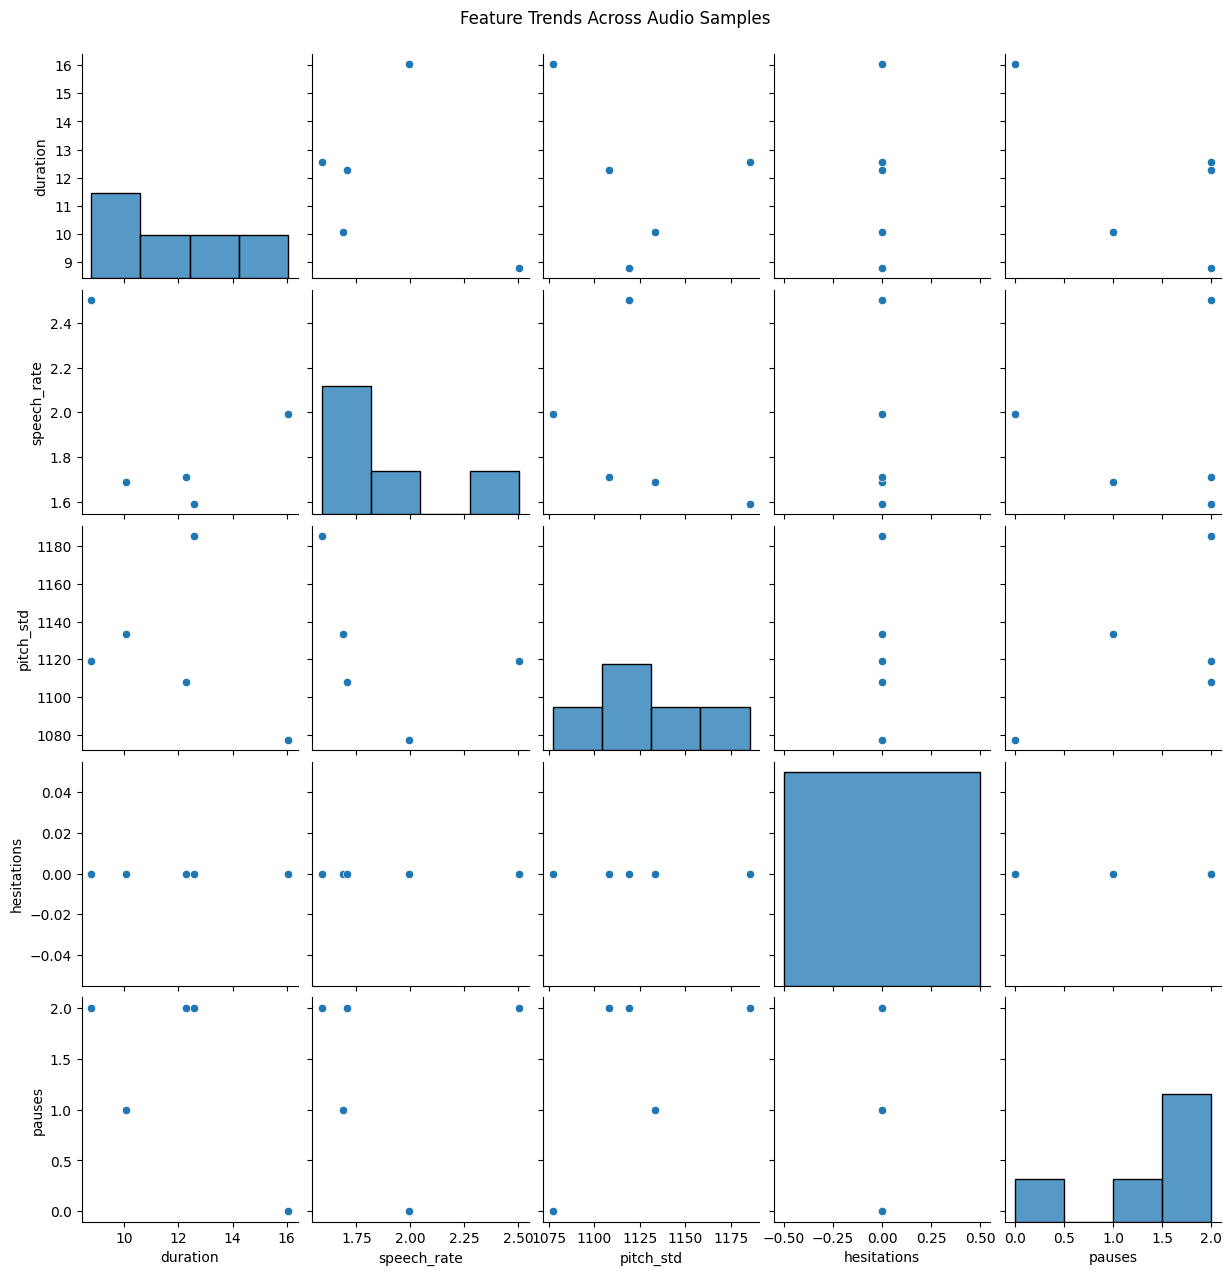

In [31]:
# STEP 6: Convert to DataFrame & Visualize
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(features)
print(df)

sns.pairplot(df.drop(columns=["file"]))
plt.suptitle("Feature Trends Across Audio Samples", y=1.02)
plt.show()


In [32]:
# STEP 7: Basic Clustering to Detect At-Risk Samples
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=["file"]))

kmeans = KMeans(n_clusters=2, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

print(df[['file', 'cluster']])


                 file  cluster
0  Recording (11).m4a        0
1  Recording (12).m4a        0
2  Recording (13).m4a        0
3  Recording (14).m4a        0
4  Recording (16).m4a        1


In [19]:
# STEP 8: Optional - Risk Score Calculation Function
def risk_score(row):
    return round((row["hesitations"] + row["pauses"]) * (1 / (row["speech_rate"] + 1)), 2)

df["risk_score"] = df.apply(risk_score, axis=1)
print(df[["file", "risk_score"]])


                 file  risk_score
0  Recording (11).m4a        0.57
1  Recording (12).m4a        0.37
2  Recording (13).m4a        0.74
3  Recording (14).m4a        0.77
4  Recording (16).m4a        0.00
